<a href="https://colab.research.google.com/github/augustoberwaldt/mackenzie/blob/main/grafos_atividade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Utilizando a fonte de dados disponibilizada para o ano de 2018 de voos brasileiros pela ANAC (dados tratados no GitHub do professor) monte uma rede complexa com as cidades brasileiras e responda as seguintes perguntas abaixo.

-----------------------------
Qual o grau médio, ou seja, número de outros aeroportos conectados, dos aeroportos brasileiros com voos em 2018?

Qual aeroporto brasileiro voava, em 2018, para mais cidades distintas?

Quais são os dois aeroportos que precisavam em 2018 de mais escalas para se interligarem?

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import math

In [28]:
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
	               'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
	                        names = airport_col, index_col = 0)
airport_df.head(20)

Name  ...       source
ID                                               ...             
1                                Goroka Airport  ...  OurAirports
2                                Madang Airport  ...  OurAirports
3                  Mount Hagen Kagamuga Airport  ...  OurAirports
4                                Nadzab Airport  ...  OurAirports
5   Port Moresby Jacksons International Airport  ...  OurAirports
6                   Wewak International Airport  ...  OurAirports
7                            Narsarsuaq Airport  ...  OurAirports
8                       Godthaab / Nuuk Airport  ...  OurAirports
9                         Kangerlussuaq Airport  ...  OurAirports
10                               Thule Air Base  ...  OurAirports
11                             Akureyri Airport  ...  OurAirports
12                          Egilsstaðir Airport  ...  OurAirports
13                         Hornafjörður Airport  ...  OurAirports
14                              Húsavík Airport  ...  OurAirports
15                           Ísafjörður Airport  ...  OurAirports
16               Keflavik International Airport  ...  OurAirports
17                       Patreksfjörður Airport  ...  OurAirports
18                            Reykjavik Airport  ...  OurAirports
19                         Siglufjörður Airport  ...  OurAirports
20                       Vestmannaeyjar Airport  ...  OurAirports

[20 rows x 13 columns]

In [29]:
def monta_pos(IATA):
  airport_pos_df = airport_df.loc[airport_df['IATA'].isin(IATA)][['IATA', 'Lat', 'Long']]
  airport_pos_df.reset_index(inplace=True)
  
  pos = {}
  for index, elem in enumerate (airport_pos_df['IATA']):    
    pos[elem] =  (airport_pos_df.loc[index ,'Long'], airport_pos_df.loc[index ,'Lat']) 

  found = len(airport_pos_df.loc[~airport_pos_df['Lat'].isnull()])
  print(f'{found} Aeroportos com Lat, Long')  

  return pos
  

def routes_top(routes_grouped_df, top):
  routes_grouped_df_top = routes_grouped_df.loc[routes_grouped_df['counts'] > top]  

  IATA_dest = set(routes_grouped_df_top['IATA_dest'].unique())
  print(f'{len(IATA_dest)} Aeroportos encontrados destinos')

  IATA_orig = set(routes_grouped_df_top['IATA_orig'].unique())  
  print(f'{len(IATA_orig)} Aeroportos encontrados origem')

  IATA = IATA_dest.union(IATA_orig)
  print(f'{len(IATA)} Aeroportos encontrados total')
  return IATA, routes_grouped_df_top

def monta_rotas(ano, top):
  ######################################################
  # Define nomes mais faceis de manipular para a tabela
  ######################################################
  '''
  0 'ICAO Empresa Aérea'	'Número Voo'	'Código Autorização (DI)'	'Código Tipo Linha'	'ICAO Aeródromo Origem'	'ICAO Aeródromoo Destino'	
  'Partida Prevista'	'Partida Real'	'Chegada Prevista'	'Chegada Real'	
  'Situação Voo'	'Código Justificativa'	'ano'	'mes'                 
  '''

  routes_col = ['company_id', 'flight_no', 'auth_code', 'line_code','ICAO_orig', 'ICAO_dest', 
                'depature_estimated', 'depature_time', 'arrival_estimated', 'arriaval_time', 
                'flight_status', 'flight_status_cause_code', 'ano', 'mes']

  #Carrega a lista do ano, porém eliminando os voos cancelados
  # routes_df = pd.read_csv(f"/content/drive/MyDrive/VRA/VRA_ANO_{ano}.csv"
  #                           ,header=0 ,names = routes_col, index_col = 0) #
  routes_df = pd.read_csv(f"https://github.com/lucianomcsilva/VRA/blob/main/VRA_ANO_2018.csv.zip?raw=true"
                            ,compression='zip' ,header=0 ,names = routes_col, index_col = 0) #

  routes_df = routes_df.loc[routes_df['flight_status'] != 'CANCELADO']

  #Agrupa, mantendo so o que entrara no grafo
  routes_grouped_df = routes_df.groupby(['ICAO_orig', 'ICAO_dest']).size().reset_index(name='counts')                          
  
  ######################################################################
  #Jaz a junção com o Airport.dat para trocar para o codigo de 3 letras
  ######################################################################
  #Join origem
  routes_grouped_df = routes_grouped_df.merge(airport_df[['ICAO', 'IATA', 'Lat', 'Long', 'Country']], how='left', left_on='ICAO_orig', right_on='ICAO')
  routes_grouped_df = routes_grouped_df[['IATA', 'Country', 'ICAO_dest', 'counts']]
  routes_grouped_df.rename(columns={'IATA': 'IATA_orig', 'Country': 'Country_orig'}, inplace = True)
  #Join Destino
  routes_grouped_df = routes_grouped_df.merge(airport_df[['ICAO', 'IATA', 'Lat', 'Long', 'Country']], how='left', left_on='ICAO_dest', right_on='ICAO')
  routes_grouped_df = routes_grouped_df[['IATA_orig', 'Country_orig', 'IATA', 'Country', 'counts']]
  routes_grouped_df.rename(columns={'IATA': 'IATA_dest', 'Country': 'Country_dest'}, inplace = True)

  #Filtra somente Brazil, e mantem somente as colunas necessarias
  routes_grouped_df = (routes_grouped_df
                        .loc[routes_grouped_df['Country_orig'] == 'Brazil']
                        .loc[routes_grouped_df['Country_dest'] == 'Brazil']
                        .loc[routes_grouped_df['IATA_orig'] != routes_grouped_df['IATA_dest']]
                        .loc[routes_grouped_df['IATA_orig'].str.len() == 3]
                        .loc[routes_grouped_df['IATA_dest'].str.len() == 3]
                        .sort_values(by=['counts'], ascending=False)
                      )
  routes_grouped_df = routes_grouped_df[['IATA_orig', 'IATA_dest', 'counts']]  
  
  #prepara os DataFrames que serão utilizados
  IATA, routes_grouped_df_top = routes_top(routes_grouped_df, top)
  pos = monta_pos(IATA)
  return routes_grouped_df_top, pos

  #lista de aeroportos nao encontrados
  #routes_grouped_df.loc[routes_grouped_df['ICAO'].isnull()]['ICAO_orig'].to_list()
  #df_anac_2015 = pd.read_csv(f"VRA_ANO_2015.csv")

In [34]:
#funcao feita pelo professor para
def desenha_grafo(ano, type='Shell', all=True):
  G = nx.Graph()
  pos = {}
  airport_brasil_df = airport_df.loc[airport_df['Country'] == 'Brazil'].loc[airport_df['IATA'].str.len() == 3]
  airport_brasil_df.reset_index(inplace=True)

  if all == True:
    for index, elem in enumerate(airport_brasil_df['IATA']):
      G.add_node(airport_brasil_df.loc[index, 'IATA'])
      pos[elem] =  (airport_brasil_df.loc[index ,'Long'], airport_brasil_df.loc[index ,'Lat']) 


  #ignorar pos, ja adicionei todos os aeroportos
  routes, pos_ignore = monta_rotas(ano, 1)
  routes.reset_index(inplace=True)
  for index, elem in enumerate(routes['IATA_orig']):
    G.add_edge(routes.loc[index, 'IATA_orig'], routes.loc[index, 'IATA_dest'])


  if all == False:  
    #Dois aeroportos desconexos. Nao faz sentido remover caso desenhe todos os aeroportos, pois haverão outros disconexos (sem voo algum, valencia = 0)
    G.remove_node('SXO')
    G.remove_node('CFO')


  options = {
      "font_size": 36,
      "node_size": 7000,
      "node_color": "#336699CC",
      "edgecolors": "#002060",
      "edge_color": "#D34817",
      "linewidths": 5,
      "width": [1+int(math.log(x, 30)) for x in routes['counts'].to_list()],
      "with_labels": True
  }

  plt.figure(figsize = (30,30))
  if type == 'Map':
    nx.draw_networkx(G, pos, **options)
    plt.savefig(f'brasil_2_map_{ano}.png', dpi=50)
  elif type == 'Random':
    nx.draw_random(G, **options)
    plt.savefig(f'brasil_2__random_{ano}.png', dpi=50)    
  elif type == 'Best':
    nx.draw(G, **options)
    plt.savefig(f'brasil_2_best_{ano}.png', dpi=50)        
  else:
    nx.draw_shell(G, **options)
    plt.savefig(f'brasil_2_shell_{ano}.png', dpi=50)

  # G.remove_node('SXO')
  # G.remove_node('CFO')

  return G

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


117 Aeroportos encontrados destinos
116 Aeroportos encontrados origem
118 Aeroportos encontrados total
118 Aeroportos com Lat, Long


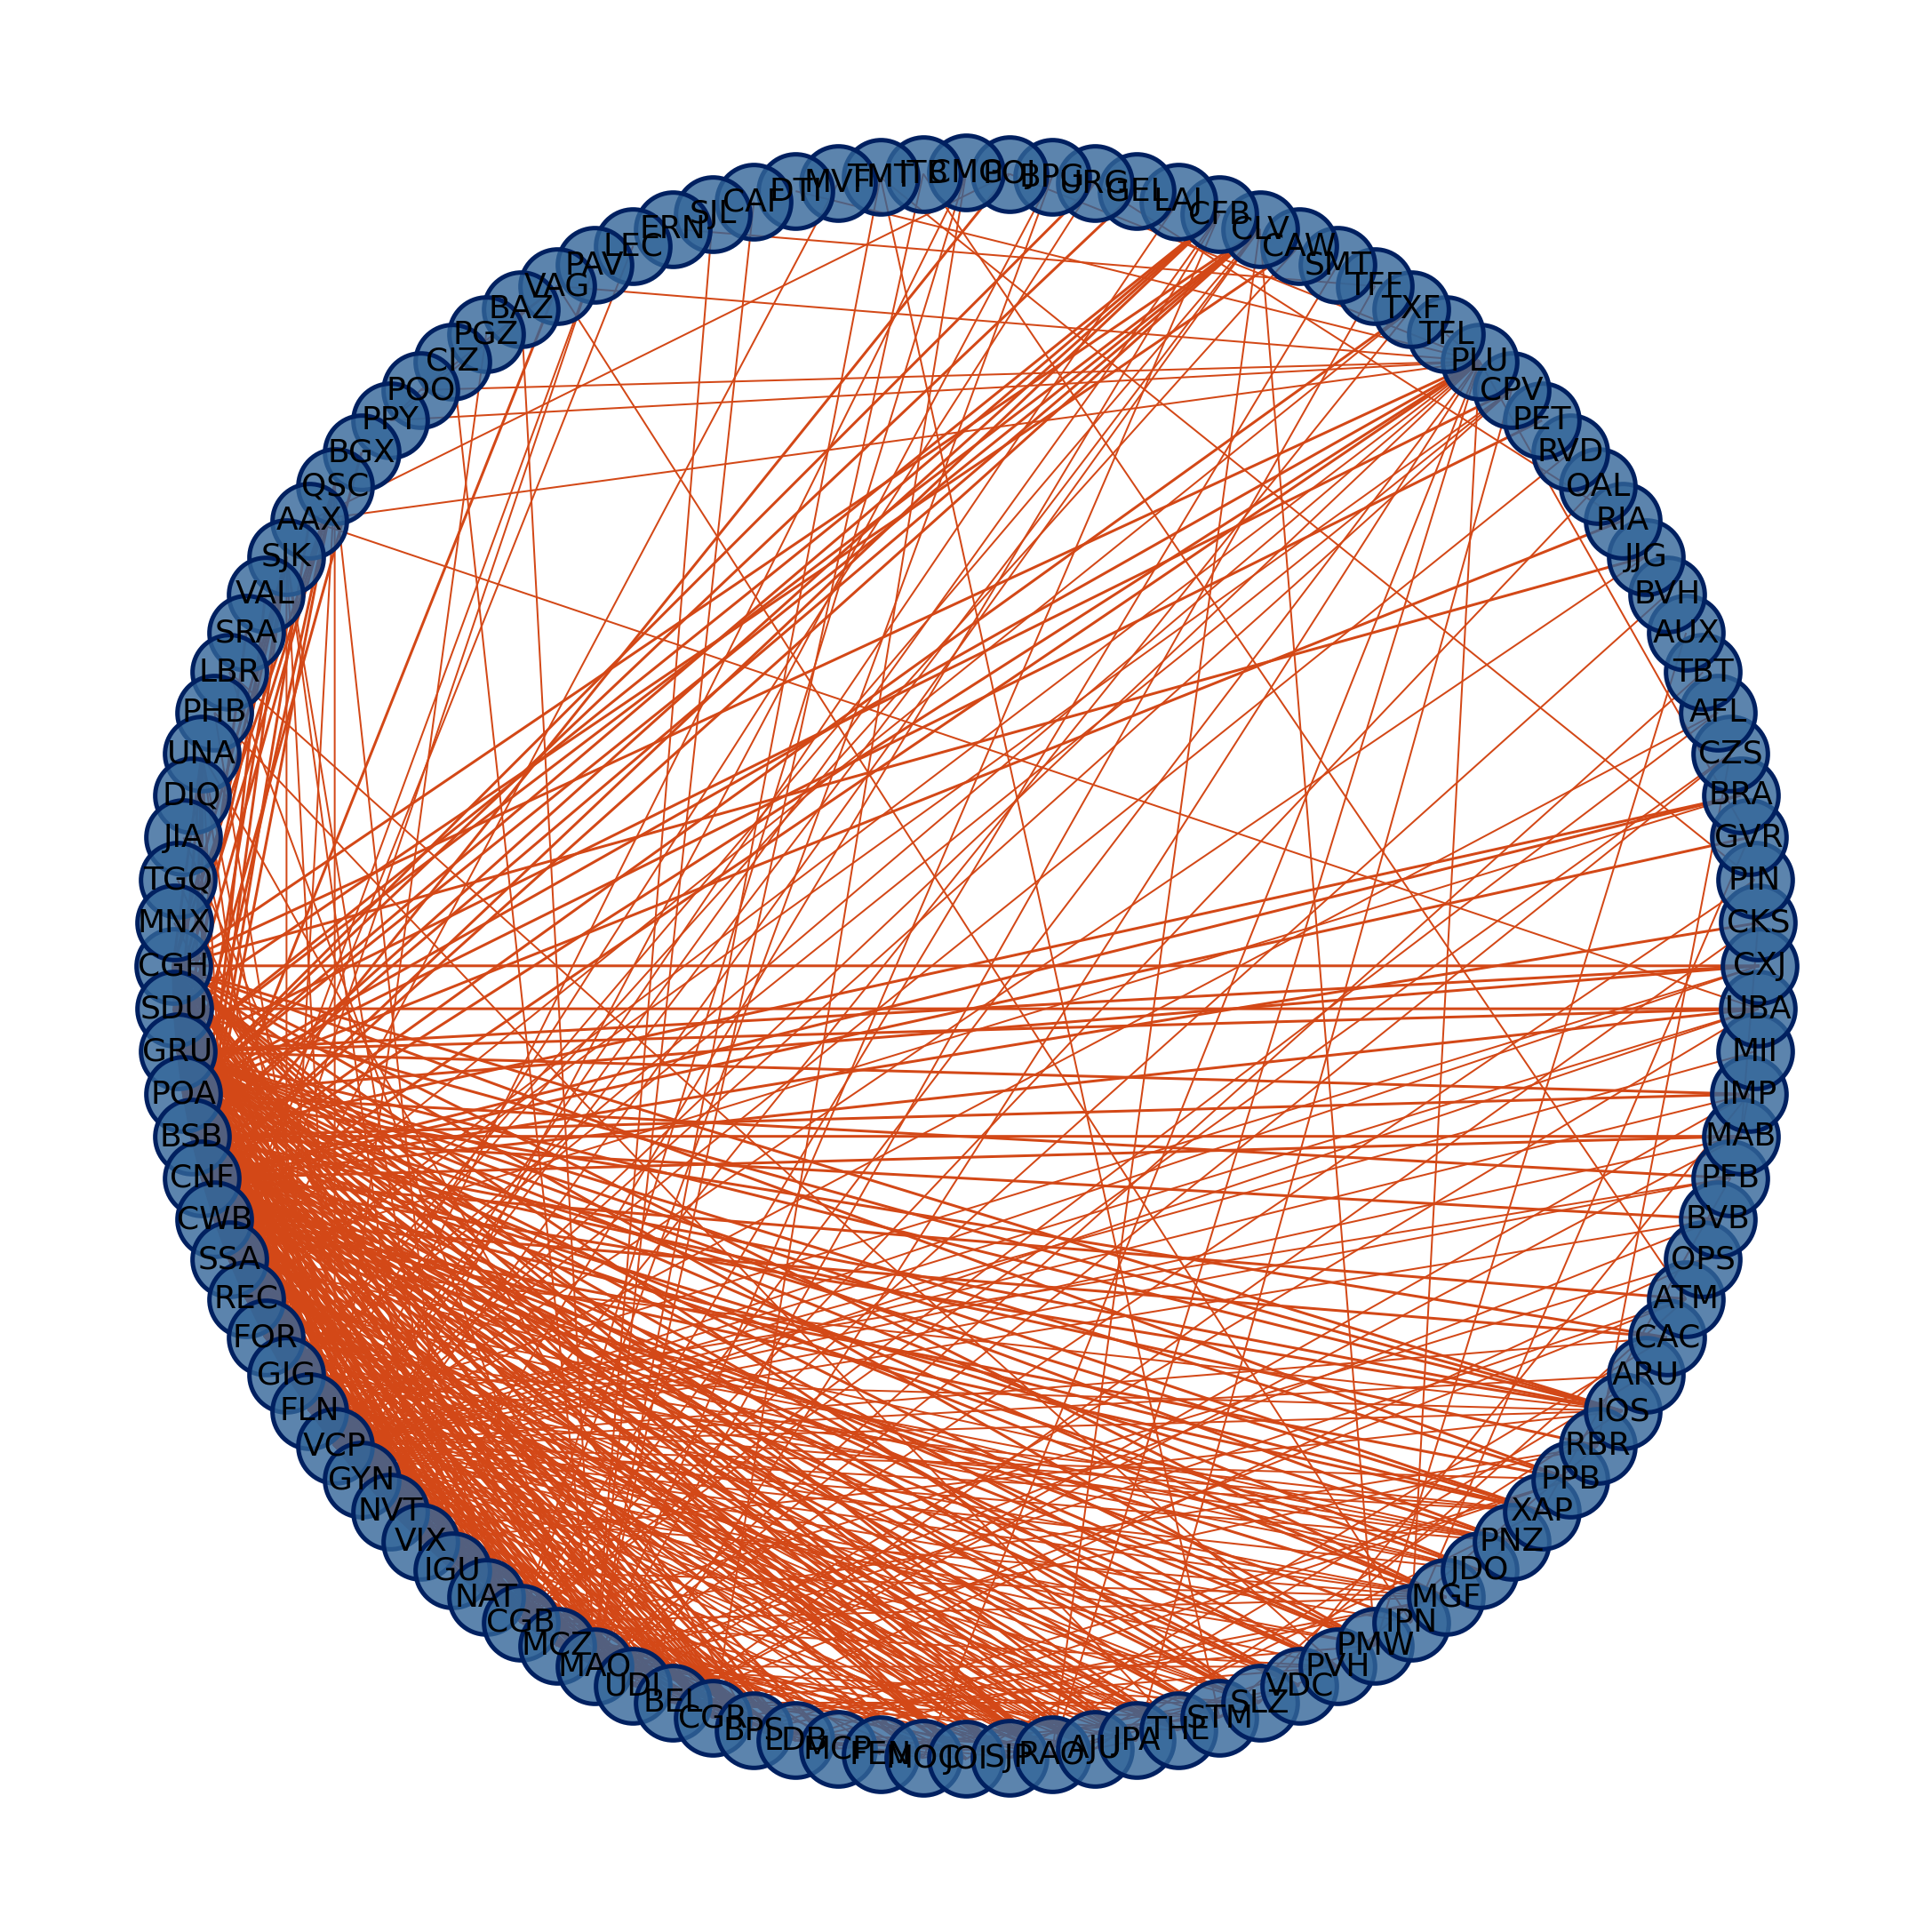

In [35]:


G=desenha_grafo("2018", 'Shell', False)




In [43]:
diameter= nx.diameter(G)
print("diameter:", diameter)
degree= nx.degree(G)
print("degree:", degree)
list(nx.shortest_path_length(G))


#Distancia entre aeroportos >> qual mais distante
sorted(list(nx.shortest_path_length(G)))

# Qual aeroporto voa para mais cidades distintas
d = list(nx.degree(G))
d.sort(key=lambda x:x[1])
d

#Grau médio
soma = 0
conta = 0
for aeroporto, grau in d:
  soma =  soma + grau
  conta = conta +1

print("Grau medio", soma/conta)

aeros = list(degree)
aeros.sort(key=lambda x:x[1])

print("Aeroporto que mais tem vaigens cidades distintas,  ('CNF', 55),('VCP', 67)");
aeros

d = sorted(list(nx.shortest_path_length(G)))
d 
#Quais são os dois aeroportos que precisavam em 2018 de mais escalas para se interligarem? 

diameter: 5
degree: [('CGH', 41), ('SDU', 23), ('GRU', 53), ('POA', 38), ('BSB', 48), ('CNF', 55), ('CWB', 26), ('SSA', 36), ('REC', 32), ('FOR', 26), ('GIG', 42), ('FLN', 18), ('VCP', 67), ('GYN', 23), ('NVT', 13), ('VIX', 18), ('IGU', 23), ('NAT', 17), ('CGB', 35), ('MCZ', 20), ('MAO', 30), ('UDI', 17), ('BEL', 20), ('CGR', 17), ('BPS', 27), ('LDB', 18), ('MCP', 5), ('FEN', 2), ('MOC', 8), ('JOI', 12), ('SJP', 11), ('RAO', 24), ('AJU', 13), ('JPA', 12), ('THE', 11), ('STM', 11), ('SLZ', 12), ('VDC', 6), ('PVH', 10), ('PMW', 10), ('IPN', 5), ('MGF', 12), ('JDO', 7), ('PNZ', 8), ('XAP', 9), ('PPB', 6), ('RBR', 5), ('IOS', 10), ('ARU', 2), ('CAC', 4), ('ATM', 5), ('OPS', 2), ('BVB', 3), ('PFB', 4), ('MAB', 6), ('IMP', 6), ('MII', 1), ('UBA', 7), ('CXJ', 5), ('CKS', 3), ('PIN', 2), ('GVR', 3), ('BRA', 3), ('CZS', 3), ('AFL', 2), ('TBT', 1), ('AUX', 1), ('BVH', 1), ('JJG', 2), ('RIA', 2), ('OAL', 1), ('RVD', 1), ('PET', 1), ('CPV', 5), ('PLU', 20), ('TFL', 1), ('TXF', 3), ('TFF', 2), ('SM

[('AAX',
  {'AAX': 0,
   'AFL': 3,
   'AJU': 2,
   'ARU': 3,
   'ATM': 2,
   'AUX': 3,
   'BAZ': 3,
   'BEL': 2,
   'BGX': 3,
   'BPG': 3,
   'BPS': 2,
   'BRA': 2,
   'BSB': 2,
   'BVB': 3,
   'BVH': 3,
   'CAC': 3,
   'CAF': 3,
   'CAW': 3,
   'CFB': 2,
   'CGB': 2,
   'CGH': 2,
   'CGR': 2,
   'CIZ': 3,
   'CKS': 2,
   'CLV': 2,
   'CMG': 3,
   'CNF': 1,
   'CPV': 3,
   'CWB': 2,
   'CXJ': 3,
   'CZS': 3,
   'DIQ': 3,
   'DTI': 2,
   'ERN': 4,
   'FEN': 3,
   'FLN': 2,
   'FOR': 2,
   'GEL': 3,
   'GIG': 2,
   'GRU': 2,
   'GVR': 2,
   'GYN': 2,
   'IGU': 2,
   'IMP': 3,
   'IOS': 2,
   'IPN': 2,
   'ITB': 3,
   'JDO': 3,
   'JIA': 3,
   'JJG': 3,
   'JOI': 3,
   'JPA': 2,
   'LAJ': 3,
   'LBR': 3,
   'LDB': 2,
   'LEC': 3,
   'MAB': 2,
   'MAO': 2,
   'MCP': 3,
   'MCZ': 2,
   'MGF': 3,
   'MII': 3,
   'MNX': 3,
   'MOC': 2,
   'MVF': 3,
   'NAT': 2,
   'NVT': 3,
   'OAL': 3,
   'OPS': 3,
   'PAV': 3,
   'PET': 3,
   'PFB': 3,
   'PGZ': 3,
   'PHB': 3,
   'PIN': 3,
   'PLU': 1,
   

In [ ]:
diameter= nx.diameter(G)
print("diameter:", diameter)
degree= nx.degree(G)
print("degree:", degree)
list(nx.shortest_path_length(G))


#Distancia entre aeroportos >> qual mais distante
sorted(list(nx.shortest_path_length(G)))

# Qual aeroporto voa para mais cidades distintas
d = list(nx.degree(G))
d.sort(key=lambda x:x[1])
d

#Grau médio
soma = 0
conta = 0
for aeroporto, grau in d:
  soma =  soma + grau
  conta = conta +1

print("Grau medio", soma/conta)

aeros = list(degree)
aeros.sort(key=lambda x:x[1])

print("Aeroporto que mais tem vaigens cidades distintas,  ('CNF', 55),('VCP', 67)");
aeros

d = sorted(list(nx.shortest_path_length(G)))
d 
#Quais são os dois aeroportos que precisavam em 2018 de mais escalas para se interligarem?

diameter: 5
degree: [('CGH', 41), ('SDU', 23), ('GRU', 53), ('POA', 38), ('BSB', 48), ('CNF', 55), ('CWB', 26), ('SSA', 36), ('REC', 32), ('FOR', 26), ('GIG', 42), ('FLN', 18), ('VCP', 67), ('GYN', 23), ('NVT', 13), ('VIX', 18), ('IGU', 23), ('NAT', 17), ('CGB', 35), ('MCZ', 20), ('MAO', 30), ('UDI', 17), ('BEL', 20), ('CGR', 17), ('BPS', 27), ('LDB', 18), ('MCP', 5), ('FEN', 2), ('MOC', 8), ('JOI', 12), ('SJP', 11), ('RAO', 24), ('AJU', 13), ('JPA', 12), ('THE', 11), ('STM', 11), ('SLZ', 12), ('VDC', 6), ('PVH', 10), ('PMW', 10), ('IPN', 5), ('MGF', 12), ('JDO', 7), ('PNZ', 8), ('XAP', 9), ('PPB', 6), ('RBR', 5), ('IOS', 10), ('ARU', 2), ('CAC', 4), ('ATM', 5), ('OPS', 2), ('BVB', 3), ('PFB', 4), ('MAB', 6), ('IMP', 6), ('MII', 1), ('UBA', 7), ('CXJ', 5), ('CKS', 3), ('PIN', 2), ('GVR', 3), ('BRA', 3), ('CZS', 3), ('AFL', 2), ('TBT', 1), ('AUX', 1), ('BVH', 1), ('JJG', 2), ('RIA', 2), ('OAL', 1), ('RVD', 1), ('PET', 1), ('CPV', 5), ('PLU', 20), ('TFL', 1), ('TXF', 3), ('TFF', 2), ('SM

[('AAX',
  {'AAX': 0,
   'AFL': 3,
   'AJU': 2,
   'ARU': 3,
   'ATM': 2,
   'AUX': 3,
   'BAZ': 3,
   'BEL': 2,
   'BGX': 3,
   'BPG': 3,
   'BPS': 2,
   'BRA': 2,
   'BSB': 2,
   'BVB': 3,
   'BVH': 3,
   'CAC': 3,
   'CAF': 3,
   'CAW': 3,
   'CFB': 2,
   'CGB': 2,
   'CGH': 2,
   'CGR': 2,
   'CIZ': 3,
   'CKS': 2,
   'CLV': 2,
   'CMG': 3,
   'CNF': 1,
   'CPV': 3,
   'CWB': 2,
   'CXJ': 3,
   'CZS': 3,
   'DIQ': 3,
   'DTI': 2,
   'ERN': 4,
   'FEN': 3,
   'FLN': 2,
   'FOR': 2,
   'GEL': 3,
   'GIG': 2,
   'GRU': 2,
   'GVR': 2,
   'GYN': 2,
   'IGU': 2,
   'IMP': 3,
   'IOS': 2,
   'IPN': 2,
   'ITB': 3,
   'JDO': 3,
   'JIA': 3,
   'JJG': 3,
   'JOI': 3,
   'JPA': 2,
   'LAJ': 3,
   'LBR': 3,
   'LDB': 2,
   'LEC': 3,
   'MAB': 2,
   'MAO': 2,
   'MCP': 3,
   'MCZ': 2,
   'MGF': 3,
   'MII': 3,
   'MNX': 3,
   'MOC': 2,
   'MVF': 3,
   'NAT': 2,
   'NVT': 3,
   'OAL': 3,
   'OPS': 3,
   'PAV': 3,
   'PET': 3,
   'PFB': 3,
   'PGZ': 3,
   'PHB': 3,
   'PIN': 3,
   'PLU': 1,
   

In [ ]:
diameter= nx.diameter(G)
print("diameter:", diameter)
degree= nx.degree(G)
print("degree:", degree)
list(nx.shortest_path_length(G))


#Distancia entre aeroportos >> qual mais distante
sorted(list(nx.shortest_path_length(G)))

# Qual aeroporto voa para mais cidades distintas
d = list(nx.degree(G))
d.sort(key=lambda x:x[1])
d

#Grau médio
soma = 0
conta = 0
for aeroporto, grau in d:
  soma =  soma + grau
  conta = conta +1

print("Grau medio", soma/conta)

aeros = list(degree)
aeros.sort(key=lambda x:x[1])

print("Aeroporto que mais tem vaigens cidades distintas,  ('CNF', 55),('VCP', 67)");
aeros

d = sorted(list(nx.shortest_path_length(G)))
d 
#Quais são os dois aeroportos que precisavam em 2018 de mais escalas para se interligarem?

diameter: 5
degree: [('CGH', 41), ('SDU', 23), ('GRU', 53), ('POA', 38), ('BSB', 48), ('CNF', 55), ('CWB', 26), ('SSA', 36), ('REC', 32), ('FOR', 26), ('GIG', 42), ('FLN', 18), ('VCP', 67), ('GYN', 23), ('NVT', 13), ('VIX', 18), ('IGU', 23), ('NAT', 17), ('CGB', 35), ('MCZ', 20), ('MAO', 30), ('UDI', 17), ('BEL', 20), ('CGR', 17), ('BPS', 27), ('LDB', 18), ('MCP', 5), ('FEN', 2), ('MOC', 8), ('JOI', 12), ('SJP', 11), ('RAO', 24), ('AJU', 13), ('JPA', 12), ('THE', 11), ('STM', 11), ('SLZ', 12), ('VDC', 6), ('PVH', 10), ('PMW', 10), ('IPN', 5), ('MGF', 12), ('JDO', 7), ('PNZ', 8), ('XAP', 9), ('PPB', 6), ('RBR', 5), ('IOS', 10), ('ARU', 2), ('CAC', 4), ('ATM', 5), ('OPS', 2), ('BVB', 3), ('PFB', 4), ('MAB', 6), ('IMP', 6), ('MII', 1), ('UBA', 7), ('CXJ', 5), ('CKS', 3), ('PIN', 2), ('GVR', 3), ('BRA', 3), ('CZS', 3), ('AFL', 2), ('TBT', 1), ('AUX', 1), ('BVH', 1), ('JJG', 2), ('RIA', 2), ('OAL', 1), ('RVD', 1), ('PET', 1), ('CPV', 5), ('PLU', 20), ('TFL', 1), ('TXF', 3), ('TFF', 2), ('SM

[('AAX',
  {'AAX': 0,
   'AFL': 3,
   'AJU': 2,
   'ARU': 3,
   'ATM': 2,
   'AUX': 3,
   'BAZ': 3,
   'BEL': 2,
   'BGX': 3,
   'BPG': 3,
   'BPS': 2,
   'BRA': 2,
   'BSB': 2,
   'BVB': 3,
   'BVH': 3,
   'CAC': 3,
   'CAF': 3,
   'CAW': 3,
   'CFB': 2,
   'CGB': 2,
   'CGH': 2,
   'CGR': 2,
   'CIZ': 3,
   'CKS': 2,
   'CLV': 2,
   'CMG': 3,
   'CNF': 1,
   'CPV': 3,
   'CWB': 2,
   'CXJ': 3,
   'CZS': 3,
   'DIQ': 3,
   'DTI': 2,
   'ERN': 4,
   'FEN': 3,
   'FLN': 2,
   'FOR': 2,
   'GEL': 3,
   'GIG': 2,
   'GRU': 2,
   'GVR': 2,
   'GYN': 2,
   'IGU': 2,
   'IMP': 3,
   'IOS': 2,
   'IPN': 2,
   'ITB': 3,
   'JDO': 3,
   'JIA': 3,
   'JJG': 3,
   'JOI': 3,
   'JPA': 2,
   'LAJ': 3,
   'LBR': 3,
   'LDB': 2,
   'LEC': 3,
   'MAB': 2,
   'MAO': 2,
   'MCP': 3,
   'MCZ': 2,
   'MGF': 3,
   'MII': 3,
   'MNX': 3,
   'MOC': 2,
   'MVF': 3,
   'NAT': 2,
   'NVT': 3,
   'OAL': 3,
   'OPS': 3,
   'PAV': 3,
   'PET': 3,
   'PFB': 3,
   'PGZ': 3,
   'PHB': 3,
   'PIN': 3,
   'PLU': 1,
   

In [ ]:
diameter= nx.diameter(G)
print("diameter:", diameter)
degree= nx.degree(G)
print("degree:", degree)
list(nx.shortest_path_length(G))


#Distancia entre aeroportos >> qual mais distante
sorted(list(nx.shortest_path_length(G)))

# Qual aeroporto voa para mais cidades distintas
d = list(nx.degree(G))
d.sort(key=lambda x:x[1])
d

#Grau médio
soma = 0
conta = 0
for aeroporto, grau in d:
  soma =  soma + grau
  conta = conta +1

print("Grau medio", soma/conta)

aeros = list(degree)
aeros.sort(key=lambda x:x[1])

print("Aeroporto que mais tem vaigens cidades distintas,  ('CNF', 55),('VCP', 67)");
aeros

d = sorted(list(nx.shortest_path_length(G)))
d 
#Quais são os dois aeroportos que precisavam em 2018 de mais escalas para se interligarem? ERN

diameter: 5
degree: [('CGH', 41), ('SDU', 23), ('GRU', 53), ('POA', 38), ('BSB', 48), ('CNF', 55), ('CWB', 26), ('SSA', 36), ('REC', 32), ('FOR', 26), ('GIG', 42), ('FLN', 18), ('VCP', 67), ('GYN', 23), ('NVT', 13), ('VIX', 18), ('IGU', 23), ('NAT', 17), ('CGB', 35), ('MCZ', 20), ('MAO', 30), ('UDI', 17), ('BEL', 20), ('CGR', 17), ('BPS', 27), ('LDB', 18), ('MCP', 5), ('FEN', 2), ('MOC', 8), ('JOI', 12), ('SJP', 11), ('RAO', 24), ('AJU', 13), ('JPA', 12), ('THE', 11), ('STM', 11), ('SLZ', 12), ('VDC', 6), ('PVH', 10), ('PMW', 10), ('IPN', 5), ('MGF', 12), ('JDO', 7), ('PNZ', 8), ('XAP', 9), ('PPB', 6), ('RBR', 5), ('IOS', 10), ('ARU', 2), ('CAC', 4), ('ATM', 5), ('OPS', 2), ('BVB', 3), ('PFB', 4), ('MAB', 6), ('IMP', 6), ('MII', 1), ('UBA', 7), ('CXJ', 5), ('CKS', 3), ('PIN', 2), ('GVR', 3), ('BRA', 3), ('CZS', 3), ('AFL', 2), ('TBT', 1), ('AUX', 1), ('BVH', 1), ('JJG', 2), ('RIA', 2), ('OAL', 1), ('RVD', 1), ('PET', 1), ('CPV', 5), ('PLU', 20), ('TFL', 1), ('TXF', 3), ('TFF', 2), ('SM

[('AAX',
  {'AAX': 0,
   'AFL': 3,
   'AJU': 2,
   'ARU': 3,
   'ATM': 2,
   'AUX': 3,
   'BAZ': 3,
   'BEL': 2,
   'BGX': 3,
   'BPG': 3,
   'BPS': 2,
   'BRA': 2,
   'BSB': 2,
   'BVB': 3,
   'BVH': 3,
   'CAC': 3,
   'CAF': 3,
   'CAW': 3,
   'CFB': 2,
   'CGB': 2,
   'CGH': 2,
   'CGR': 2,
   'CIZ': 3,
   'CKS': 2,
   'CLV': 2,
   'CMG': 3,
   'CNF': 1,
   'CPV': 3,
   'CWB': 2,
   'CXJ': 3,
   'CZS': 3,
   'DIQ': 3,
   'DTI': 2,
   'ERN': 4,
   'FEN': 3,
   'FLN': 2,
   'FOR': 2,
   'GEL': 3,
   'GIG': 2,
   'GRU': 2,
   'GVR': 2,
   'GYN': 2,
   'IGU': 2,
   'IMP': 3,
   'IOS': 2,
   'IPN': 2,
   'ITB': 3,
   'JDO': 3,
   'JIA': 3,
   'JJG': 3,
   'JOI': 3,
   'JPA': 2,
   'LAJ': 3,
   'LBR': 3,
   'LDB': 2,
   'LEC': 3,
   'MAB': 2,
   'MAO': 2,
   'MCP': 3,
   'MCZ': 2,
   'MGF': 3,
   'MII': 3,
   'MNX': 3,
   'MOC': 2,
   'MVF': 3,
   'NAT': 2,
   'NVT': 3,
   'OAL': 3,
   'OPS': 3,
   'PAV': 3,
   'PET': 3,
   'PFB': 3,
   'PGZ': 3,
   'PHB': 3,
   'PIN': 3,
   'PLU': 1,
   